## Biases as Diagonals

Recall that the MPF cost function is given by:

$$K(\theta) = \frac{\epsilon}{|D|}\sum_{j \in D}\sum_{i\notin D}g_{ij}\exp\left(\frac{1}{2}(E_j(\theta)-E_i(\theta))\right)$$

with

$$E_i(\theta) = E_{x}(W,b) = -\frac{1}{2}x^TWx-bx$$

and the $W$ matrix being symmetric and having zeros as its diagonal entries. With some neat manipulation and using the properties of $W$, we managed to simply the cost function to a mere

$$K(\theta) = C \sum_{x \in D}\sum_{h=1}^{d}\exp\left[\left(1/2-x\right)_h(Wx+b)_h\right]$$

However, the diagonal of zeros seems to be causing some problems in the gradient descent portion of the learning; 

We now consider $W$ to be symmetric with the biases filled in the entries of the previously zero diagonals. Considering $x$ and $\tilde{x}$ be two states that are just one hop away,

$$E_{x}(\theta)-E_{\tilde{x}}(\theta) =-\frac{1}{2}x^TWx + \frac{1}{2}\tilde{x}^TW\tilde{x}$$

we can do a simple expansion which gives 

$$ \frac{1}{2}(\tilde{x}^TW\tilde{x} -\tilde{x}^TWx + \tilde{x}^TWx - x^TWx )$$

after some simplification we get

$$\frac{1}{2}z^TWy$$

where $z = \tilde{x} + x$ and $y = \tilde{x} -x$. Without loss of generality, let the following be given which $h$ being the index where the one hop occur,

$$\tilde{x}=\begin{pmatrix}x_1\\ \vdots\\ x_h\\ \vdots\\ x_n\end{pmatrix} \quad x = \begin{pmatrix}x_1\\ \vdots\\1-x_h\\ \vdots\\ x_n\end{pmatrix}$$

Expressing $z$ and $y$ explicitly, we have

$$z=\begin{pmatrix}2x_1\\ \vdots\\ 1\\ \vdots\\ 2x_n\end{pmatrix} \quad y = \begin{pmatrix}0\\ \vdots\\2x_h-1\\ \vdots\\ 0\end{pmatrix}$$


thus



$$\frac{1}{2}(E_{x}(\theta)-E_{\tilde{x}}(\theta)) = \frac{1}{4}z^TWy = \begin{pmatrix}x_1(x_h-1/2)W_{1h}, \ldots,1/2(x_h-1/2)W_{hh}\ldots,x_n(x_h-1/2)W_{nh} \end{pmatrix} $$


which in words means for the hop occuring in index $h$, $\frac{1}{2}z^TWy$ is $(x_h-1/2)W_h$ where $W_h$ represents the $h$ column of $W$, multiplied by $2x_k$ for $k \neq h$.

After talking with Shaowei:

$$(x_h-1/2)*(W_{h1}x_1+...+W_{hn}x_n - W_{hh}x_h+ 1/2 W_{hh})$$

$$(x_h-1/2)*(Res_h - W_{hh}(x_h-1/2))$$

$$Delta = x_h - 1/2$$

$$Delta * (Res - Diag(W) * Delta)$$

$$Res = Wx$$

$$\frac{1}{2}(E_{x}(\theta)-E_{\tilde{x}}(\theta))=\frac{1}{4}z^tWy = (x_h-1/2)\ast(W_{h1}x_1+...+W_{hn}x_n - W_{hh}x_h+ 1/2 W_{hh})$$

Let $Res = Wx$ and $\delta = x_h - 1/2$,

$$(x_h-1/2)*(Res_h - W_{hh}(x_h-1/2))\quad\text{for each row}$$

$$\delta * Res - 1/4 * diag(W)\quad\text{ since } \delta^2 = 1/4$$


Use matrix multiplications as much as possible

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os
import timeit

%matplotlib inline

In [2]:
def load_data(dataset = '16-50K.npy', borrow = True):
    """
    Loads the dataset.
    """

    data = np.load(dataset)
    dataset = theano.shared(np.asarray(data, dtype = theano.config.floatX), borrow = borrow)

    return dataset

In [23]:
class mpf(object):
    """
    Minimum probability flow
    """
    
    def __init__(self, input = None, n = 32, temperature = 1,  W = None):
        
        self.n = n
        self.temperature = temperature
        U = np.random.rand(self.n, self.n)
        R = 0.5 * (U + U.T)
#         np.fill_diagonal(R, 0)

        if not W:
            initial_W = np.asarray(R, dtype = theano.config.floatX)
            W = theano.shared(initial_W, name = 'W', borrow = True)

#         if not b:
#             initial_b = np.asarray(np.random.rand(n), dtype = theano.config.floatX)
#             b = theano.shared(initial_b, name = 'b', borrow = True)


        self.W = W
#         self.b = b
        
        if input is None:
            self.x = T.dmatrix(name = 'input')
        else:
            self.x = input

        self.params = [self.W]
    
    
    def cost(self, lr = 1e-2, epsilon = 1):
        """
        Returns the cost of vanilla SGD. 
        The update rule enforces that the W matrix at each timestep is symmetric.
        """
         
        print (51 * '=')
        print (24 * '#' + 'MPF' + 24 * '#')
        print (51 * '=')
        print ('Input size: {0}'.format(self.n))
        print ('Learning temperature: {0}'.format(self.temperature))
        print ('Learning rate: {0}'.format(lr))
        
        cost = T.mean(T.exp(((self.x - 0.5) * T.dot(self.x, self.W)) \
                            - .25 * (self.W - T.fill_diagonal(self.W, 0)))) * epsilon
#         cost = T.mean(T.exp((0.5 - self.x) * (T.dot(self.x, self.W) + self.b))) * epsilon
        Wgrad = T.grad(cost, self.W)

        Wupdate = 0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T)
#         Wupdate = 0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T)
#         Wupdate = self.W - (lr * Wgrad)
        updates = [(self.W, Wupdate)]
#         bupdate = self.b - lr *(T.diag(0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T)) + bgrad)
#         Wupdate = T.fill_diagonal(0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T), 0)        
#         updates = [(self.W, Wupdate), (self.b, bupdate)]

        return cost, updates

In [24]:
def trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy'):
    """
    Trains parameters using MPF.
    """
    
    index = T.lscalar()
    x = T.matrix('x')
    flow = mpf(input = x, n = units, temperature = temperature)
    
    cost, updates = flow.cost(lr = lr, epsilon = epsilon)
    
    dataset = load_data(sample)
    n_dataset_batches = dataset.get_value(borrow = True).shape[0] // batchsize

    print ('Sample used: {0}'.format(sample))
    print ('=' * 51)
    
    mpf_cost = theano.function(inputs = [index], outputs = cost, updates = updates, \
                                givens = {x: dataset[index * batchsize: (index + 1) * batchsize]})
    
    start_time = timeit.default_timer()
    
    best_mse = np.inf
    best_W = [None, np.inf]
    best_b = [None, np.inf]
    
    for epoch in range(n_epochs):
        c = []
        current_time = timeit.default_timer()
        for batch_index in range(n_dataset_batches):
            c.append(mpf_cost(batch_index))
        
        W_learnt = flow.W.get_value(borrow = True)
        np.fill_diagonal(W_learnt, 0)
        b_learnt = np.diag(W_learnt)
        
        W = np.load(sample[0:2] + '-' + 'W' + '.npy')
        b = np.load(sample[0:2] + '-' + 'b' + '.npy')
        
        mseW = np.linalg.norm(W - W_learnt)/ (units**2 - units)/2
        mseb = np.linalg.norm(b - b_learnt)/ units
#         mse = (mseW * mseb)/(mseW + mseb)
        mse = mseW + mseb
        
        if mse < best_mse:
            best_mse = mse
            best_W[0] = W_learnt  #flow.W.get_value(borrow = True)
            best_W[1] = mseW
            best_b[0] = b_learnt  #flow.b.get_value(borrow = True)
            best_b[1] = mseb
            best_cost = np.mean(c, dtype='float64')
            best_epoch = epoch
        
        if epoch%validate_every == 0:
            print ('Training epoch %d/%d, Cost: %f mseW: %.5f, mseb: %.5f, mse: %.5f Time Elasped: %.2f '\
                 % (epoch, n_epochs, np.mean(c, dtype='float64'), \
                 mseW, mseb, mse, (current_time - start_time)/60) )
    
    end_time = timeit.default_timer()

    training_time = end_time - start_time
    
    fig, ax = plt.subplots(2, figsize=(20,10))
    fig.tight_layout()

    ax[0].plot(W.reshape(-1,1)[0:100], 'b')
    ax[0].plot(W_learnt.reshape(-1,1)[0:100], 'r')
    ax[0].set_title('W')
    ax[0].legend(['W', 'Learnt W'])
    ax[1].plot(b.reshape(-1,1), 'b')
    ax[1].plot(b_learnt.reshape(-1,1),'r')
    ax[1].set_title('b')
    ax[1].legend(['b', 'Learnt b'])

    
    print ('The training took %.2f minutes' % (training_time/60.))
    print ('#' * 22 + 'Results' + '#' * 22)
    print ('=' * 51)
    print ('Best mse: {0}'.format(mse))
    print ('Best W mse: {0}'.format(mseW))
    print ('Best b mse: {0}'.format(mseb))
    print ('=' * 51)

########################MPF########################
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 1.107823 mseW: 0.02970, mseb: 0.27599, mse: 0.30568 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.636892 mseW: 0.04595, mseb: 0.27599, mse: 0.32193 Time Elasped: 0.52 
Training epoch 200/1000, Cost: 0.636117 mseW: 0.04755, mseb: 0.27599, mse: 0.32354 Time Elasped: 1.03 
Training epoch 300/1000, Cost: 0.635972 mseW: 0.04814, mseb: 0.27599, mse: 0.32412 Time Elasped: 1.54 
Training epoch 400/1000, Cost: 0.635935 mseW: 0.04841, mseb: 0.27599, mse: 0.32439 Time Elasped: 2.03 
Training epoch 500/1000, Cost: 0.635924 mseW: 0.04854, mseb: 0.27599, mse: 0.32453 Time Elasped: 2.53 
Training epoch 600/1000, Cost: 0.635921 mseW: 0.04861, mseb: 0.27599, mse: 0.32459 Time Elasped: 3.04 
Training epoch 700/1000, Cost: 0.635919 mseW: 0.04865, mseb: 0.27599, mse: 0.32463 Time Elasped: 3.56 
Training epoch 800/1000, Cost: 0.635919 mse

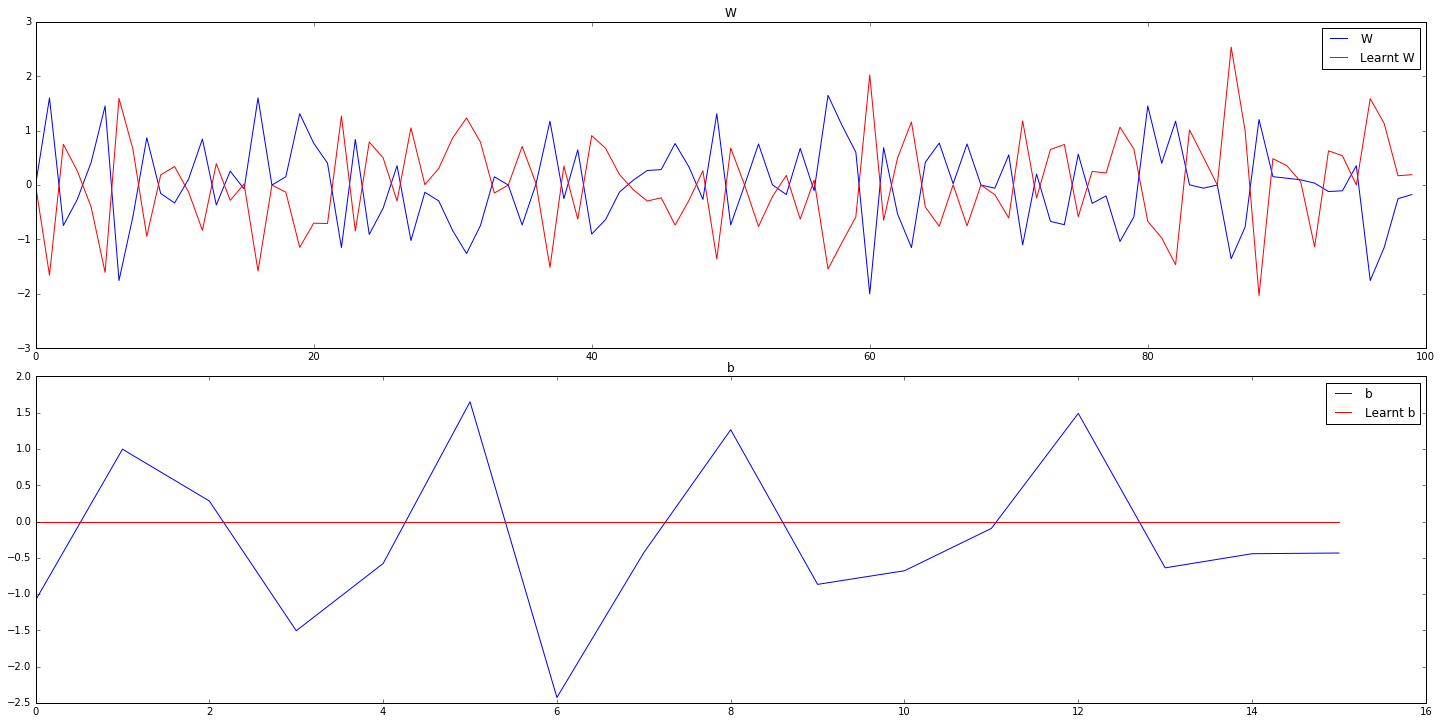

In [17]:
trainmpf(units = 16, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

In [25]:
trainmpf(units = 16, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

########################MPF########################
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: nan mseW: nan, mseb: 0.27599, mse: nan Time Elasped: 0.00 
Training epoch 100/1000, Cost: nan mseW: nan, mseb: 0.27599, mse: nan Time Elasped: 0.54 
Training epoch 200/1000, Cost: nan mseW: nan, mseb: 0.27599, mse: nan Time Elasped: 1.08 
Training epoch 300/1000, Cost: nan mseW: nan, mseb: 0.27599, mse: nan Time Elasped: 1.62 


KeyboardInterrupt: 